# Analysing Cyberpunk 2077 steam reviews
### Spring 2024 Data Science Project

### Project members
 - Aryan Tajne
 - Dahong Luo

### Why we chose this dataset?

We chose this dataset because we are heavily invested in the entire lifecycle of the game Cyberpunk 2077. Since it's release, the game has recieved heavy criticism for it's performance and bugs. We wanted to see if the reviews on steam reflected the same sentiment in the beginning as well as analyse how the game improved over time.

### Questions we have
We are interested in how many upvotes and funny votes the review gets. Reviews with more upvotes generally means that the review is helpful to other users. By estimating the number of upvotes on the review, we can push the review upwards so that other users can see it.

### Contribution Checkpoints

A: Project idea - 5%  
B: Dataset Curation and Preprocessing - 10%  
C: Data Exploration and Summary Statistics - 10%  
D: ML Algorithm Design/Development - 25%  
E: ML Algorithm Training and Test Data Analysis - 20%  
F: Visualization, Result Analysis, Conclusion - 15%  
G: Final Tutorial Report Creation - 10%  
H: Additional (not listed above, if any) - 5%  

Member 1: Aryan Tajne, Contribution 100%  
Member 2: Dahong Luo, Contribution 100%  

We, all team members, agree together that the above information is true, and we are confident about our contributions to this submitted project/final tutorial.
 - Aryan Tajne, May 7, 2024
 - Dahong Luo, May 7, 2024

### Contribution Summary
 - Aryan Tajne
    - ...
 - Dahong Luo
    - ...

# __Data Curation__
## Data Source

We got a dataset from Kaggle which contains the reviews of Cyberpunk 2077 from the steam platform.

https://www.kaggle.com/datasets/kamilneumann/cyberpunk-2077-steam-reviews

Unfortunately, the dataset is too large to be uploaded to GitHub. However, the dataset can be downloaded from the link above.

## dependencies

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import seaborn as sns
from scipy.stats import ttest_ind

## creating a dataframe

In [78]:
df = pd.read_csv("cyberpunk_2077_filtered.csv")
df.head()

,language,review,updated,voted_up,votes_up,votes_funny,steam_purchase,playtime_at_review
0,english,It's very fun. I don't usually like open world...,2023-12-13,True,0,0,True,2452
1,french,loved it before 2.0\n\n\n\n\ndon't like it any...,2023-12-13,False,0,0,False,3349
2,schinese,真的值得体验一下,2023-12-13,True,0,0,True,2116
3,english,Fun game,2023-12-13,True,0,0,True,10324
4,english,cyberpunk,2023-12-13,True,0,0,True,1580


## Description of the dataset
 - __language__ (_str_): Language of the review
 - __review__ (_str_): The review text
 - __updated__ (_date_): Time the review was updated or posted
 - __voted_up__ (_bool_): Whether the reviewer voted up for the game
 - __votes_up__ (_int_): The number of upvotes on the review
 - __votes_funny__ (_int_): The number of "funny" votes on the review
 - __steam_purchase__ (_bool_): Whether the reviewer purchased the game on steam or not
 - __playtime_at_review__ (_int_): The playtime of the reviewer at the time of the review in minuets

# __Exploratory Data Analysis__

## Data Preprocessing

In [79]:
# change column names
df.columns = ["language", "review", "date", "voted_up_for_game", "upvotes_on_comment", "funny_votes_on_comment", "steam_purchase", "hours_played"]

# convert data types
df["language"] = df["language"].astype(str)
df["review"] = df["review"].astype(str)
df["date"] = pd.to_datetime(df["date"])
#df["voted_up_to_game"] = df["voted_up_for_game"].astype(int)
#df["steam_purchase"] = df["steam_purchase"].astype(int)

# converting playtime_at_review to hours_played
df["hours_played"] = df["hours_played"] / 60
# dropping outliers ( > 3 std deviations from the mean)
df = df[df["hours_played"] < df["hours_played"].mean() + 3 * df["hours_played"].std()]

df.head()

,language,review,date,voted_up_for_game,upvotes_on_comment,funnies_on_comment,steam_purchase,hours_played
0,english,It's very fun. I don't usually like open world...,2023-12-13,True,0,0,True,40.866667
1,french,loved it before 2.0\n\n\n\n\ndon't like it any...,2023-12-13,False,0,0,False,55.816667
2,schinese,真的值得体验一下,2023-12-13,True,0,0,True,35.266667
3,english,Fun game,2023-12-13,True,0,0,True,172.066667
4,english,cyberpunk,2023-12-13,True,0,0,True,26.333333


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 606133 entries, 0 to 612379
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   language            606133 non-null  object        
 1   review              606133 non-null  object        
 2   date                606133 non-null  datetime64[ns]
 3   voted_up_for_game   606133 non-null  bool          
 4   upvotes_on_comment  606133 non-null  int64         
 5   funnies_on_comment  606133 non-null  int64         
 6   steam_purchase      606133 non-null  bool          
 7   hours_played        606133 non-null  float64       
dtypes: bool(2), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 33.5+ MB


## Data Exploration

### upvote rate over time

<Axes: title={'center': 'Upvote Rate over Time'}, xlabel='Date', ylabel='Upvote Rate'>

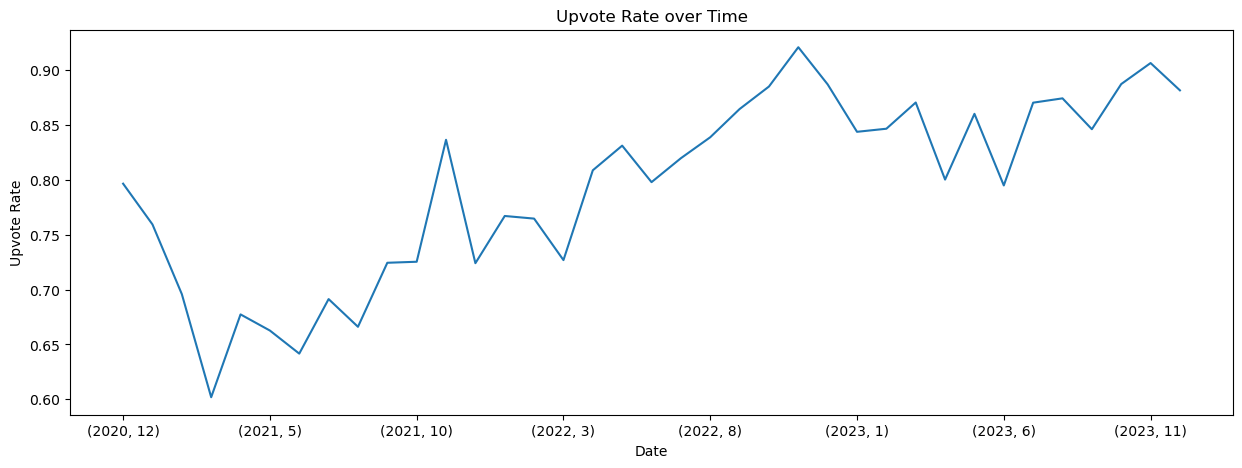

In [81]:
upvote_rate = df.groupby([df['date'].dt.year, df['date'].dt.month])["voted_up_for_game"].mean()
upvote_rate.plot(kind="line", figsize=(15, 5), title="Upvote Rate over Time", xlabel="Date", ylabel="Upvote Rate")

### Hours played statistics

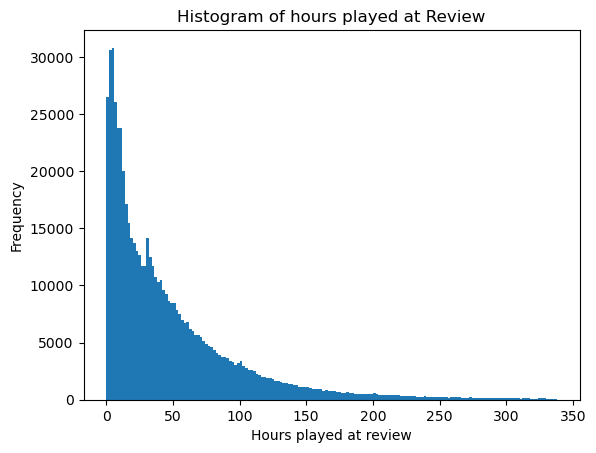

In [82]:
# Create a histogram
plt.hist(df['hours_played'], bins=int(df['hours_played'].max()/2))

# Add labels and title
plt.xlabel('Hours played at review')
plt.ylabel('Frequency')
plt.title('Histogram of hours played at Review')

# Show the histogram
plt.show()


## Hypothesis Testing
*for the tests, our alpha will be 0.05*

### hypothesis 1: the longer the playtime, the more likely the review is positive


*HO:* longer playtime does not affect the voted up rate

*HA:* longer playtime affects the voted up rate

In [83]:
# performing logistic regression

df["intercept"] = 1
print(df[["hours_played", "intercept"]].shape)
logit_model = sm.Logit(df["voted_up_for_game"], df[["hours_played", "intercept"]])
result = logit_model.fit()

print(result.summary())

(606133, 2)
Optimization terminated successfully.
         Current function value: 0.488026
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      voted_up_for_game   No. Observations:               606133
Model:                          Logit   Df Residuals:                   606131
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 May 2024   Pseudo R-squ.:                 0.01342
Time:                        00:49:10   Log-Likelihood:            -2.9581e+05
converged:                       True   LL-Null:                   -2.9983e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
hours_played     0.0065   7.86e-05     82.328      0.000       0.006       0.007
intercept  

Since the P value of hours_played of 0.000 denoted by P>|z| is less than 0.05, we can reject the null hypothesis.  
Therefore, the longer the playtime, the more likely the review is positive.

C:\Users\Dahong Luo\AppData\Local\Temp\ipykernel_26768\1881918398.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(bins)['voted_up_for_game'].mean()


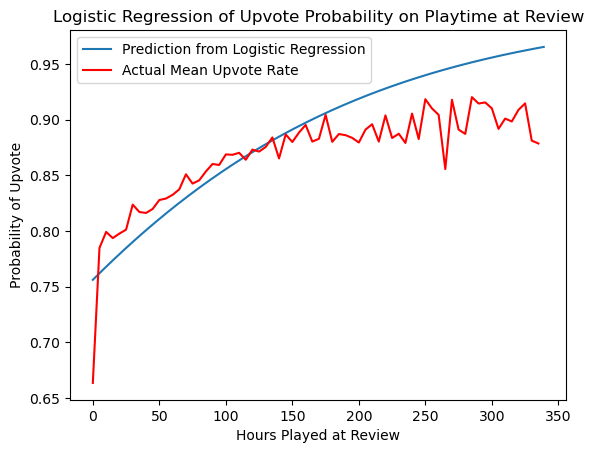

In [84]:
playtime_range = np.arange(0, df['hours_played'].max() + 1, 1)
probabilities = result.predict(np.array([playtime_range,np.ones(playtime_range.shape)]).T)
plt.plot(playtime_range, probabilities)

step = 5
bins = pd.cut(df['hours_played'], bins=range(0, int(df['hours_played'].max()+step), step))
grouped_df = df.groupby(bins)['voted_up_for_game'].mean()
plt.plot(np.arange(0, df['hours_played'].max(), step), grouped_df, color='red')


plt.xlabel('Hours Played at Review')
plt.ylabel('Probability of Upvote')
plt.legend(['Prediction from Logistic Regression', 'Actual Mean Upvote Rate'])
plt.title('Logistic Regression of Upvote Probability on Playtime at Review')
plt.show()

### hypothesis 2: Those who did not buy the game on steam are most likely trolls and will not vote up
*HO:* buying the game on steam does not affect the voted up rate

*HA:* buying the game on steam affects the voted up rate

In [85]:

contingency = pd.crosstab(df["voted_up_for_game"], df["steam_purchase"])
result = chi2_contingency(contingency)
print(result)

Chi2ContingencyResult(statistic=1903.13689134948, pvalue=0.0, dof=1, expected_freq=array([[ 12564.97788439, 106176.02211561],
       [ 51575.02211561, 435816.97788439]]))


The statistic is a really high number at 1903.13689134948 and the p-value is 0.0 which is less than 0.05, so we can reject the null hypothesis.  
This is a strong evidence that online trolls literally just voted down the game without even buying it.

<Axes: xlabel='steam_purchase', ylabel='voted_up_for_game'>

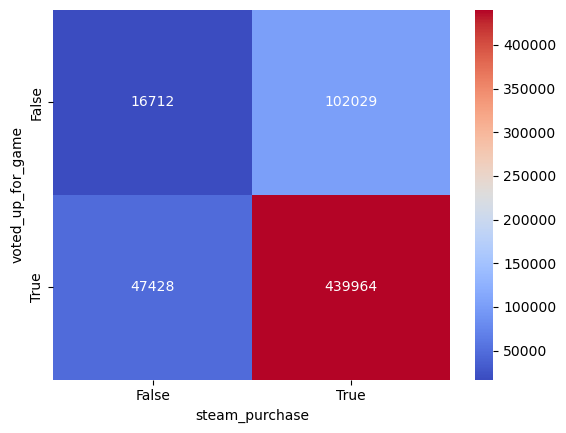

In [92]:
sns.heatmap(contingency, annot=True, cmap='coolwarm', fmt='d')

### hypothesis 3: ascii art = more upvotes
*H0:* reviews having ascii art have the same average upvote rate as reviews without ascii art.

*HA:* reviews having ascii art have a higher average upvote rate than reviews without ascii art.

In [93]:
#alll ascii art on steam have the braille symbols which have the unicode range of 2800 to 28FF
df['has_ascii_art'] = df['review'].apply(lambda x: True if any(c for c in x if ('\u2800' <= c <= '\u28FF')) else False)

In [97]:
ascii_art = df[df['has_ascii_art']]
no_ascii_art = df[~df['has_ascii_art']]
t_stat, p_val = ttest_ind(ascii_art["upvotes_on_comment"] + ascii_art["funny_votes_on_comment"], no_ascii_art['upvotes_on_comment']+ no_ascii_art['funny_votes_on_comment'], alternative='greater')

print(f"p-value: {p_val}")

p-value: 4.560562825877745e-24


Since the p-value of 4.560562825877745e-24 is less than the alpha value 0.05, we reject the null hypothesis and conclude that reviews with ascii art have a higher average upvote rate than reviews without ascii art.

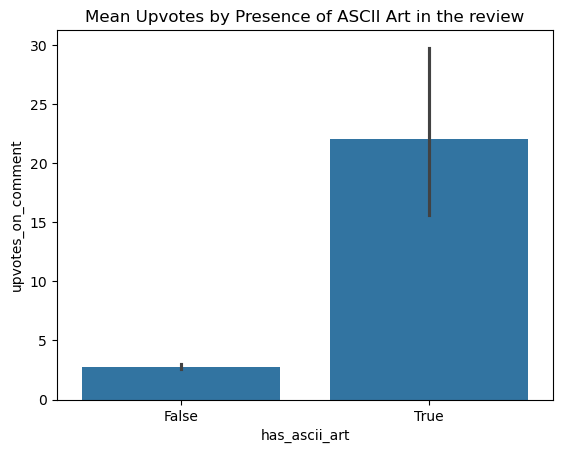

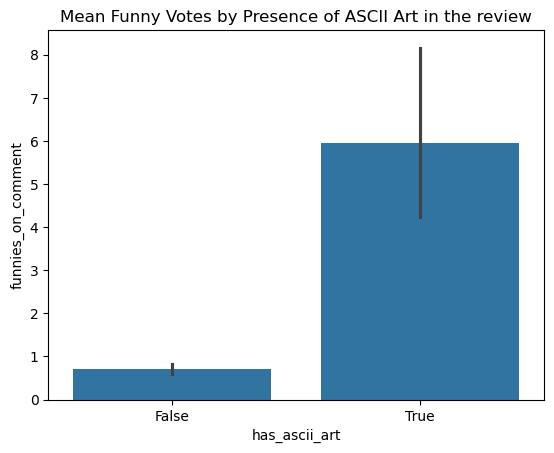

In [98]:
sns.barplot(x='has_ascii_art', y='upvotes_on_comment', data=df, estimator=np.mean)
plt.title('Mean Upvotes by Presence of ASCII Art in the review')
plt.show()

sns.barplot(x='has_ascii_art', y='funny_votes_on_comment', data=df, estimator=np.mean)
plt.title('Mean Funny Votes by Presence of ASCII Art in the review')
plt.show()

## Exploratory Data Analysis Conclusion
...

# __Primary Data Analysis__